In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from collections import Counter
import re
from scipy import stats
import shap
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D  
import plotly.express as px
from datetime import timedelta

In [3]:
df = pd.read_csv("DID_FINAL_SLURM_OCT_2023_aggregated.csv")

df.head()

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.



,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
0,0,31496544,user_679,group_121,2023-03-21T11:13:45,Unknown,Unknown,00:00:00,PENDING,account_017,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
1,1,31497932,user_679,group_121,2023-03-21T11:31:18,Unknown,Unknown,00:00:00,PENDING,account_017,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
2,2,31993628,user_105,group_114,2023-03-22T18:19:12,Unknown,Unknown,00:00:00,PENDING,account_017,...,0,12,0,150G,NaN,1,1,None assigned,"billing=23347,cpu=12,gres/gpu=8,mem=150G,node=1",NaN
3,3,39087660,user_652,group_054,2023-04-04T13:09:10,Unknown,Unknown,00:00:00,PENDING,account_017,...,0,640,0,20G,NaN,10,10,None assigned,"billing=3112,cpu=640,mem=20G,node=10",NaN
4,4,59062820,user_188,group_046,2023-05-08T09:58:20,2024-01-01T00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,...,360,40,40,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"


Pre-Processing Data

In [3]:
#Pre-Processing with Shams Code
slurm=df.copy()
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])
slurm['End'] = pd.to_datetime(slurm['Start'])

In [4]:
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if isinstance(mem_str, (int, float, complex)):   # if its a numeric type zero
        return float(mem_str)
    elif mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    else:
        return float(mem_str)    # when its a string zero '0'

In [5]:
# First drop rows with NA requested memory
slurm= slurm.dropna(subset=['ReqMem'])
slurm= slurm.dropna(subset=['MaxRSS'])


slurm['ReqMem_MB'] = slurm['ReqMem'].apply(convert_memory)
slurm['MaxRSS_MB'] = slurm['MaxRSS'].apply(convert_memory)

In [6]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm['Timelimit_'] = slurm['Timelimit'].apply(parse_time_string)
slurm['total_minutes'] = slurm['Elapsed'].apply(parse_time_string)

slurm['total_minutes'] = pd.to_timedelta(slurm['total_minutes']).dt.total_seconds() / 60  # Convert Elapsed time to hours
slurm['Timelimit_'] = pd.to_timedelta(slurm['Timelimit_']).dt.total_seconds() / 60  # Convert Elapsed time to hours

df=slurm.copy()

Feature Set (Numeric Variables)

In [7]:
#Feature Set to be used in Numerical Clustering models (Anything using PCA)
features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_','ReqMem_MB']

Dimesnion Reduction via PCA

In [40]:

pca3=PCA(3)

df_pca3=df[features3]
df_pca3=np.log10(df_pca3)
df_pca3 = pca3.fit_transform(df_pca3)


pca2=PCA(2)

df_pca2=df[features3]
df_pca2=np.log10(df_pca2)
df_pca2 = pca2.fit_transform(df_pca2)

In [41]:
df_pca3 = pd.DataFrame(df_pca3, columns=['1st feature', 
                                          '2nd feature',
                                          '3rd feature'])
df_pca2 = pd.DataFrame(df_pca2, columns=['1st feature', 
                                          '2nd feature'])
df_pca3

,1st feature,2nd feature,3rd feature
0,4.496051,0.778034,1.505580
1,4.457472,0.793370,1.496210
2,4.445893,0.797972,1.493398
3,4.459311,0.792638,1.496657
4,4.461650,0.791709,1.497225
...,...,...,...
1449977,-0.339319,2.302176,-0.450351
1449978,0.566273,0.290256,0.546012
1449979,2.818491,0.375392,0.140060
1449980,2.807200,0.379880,0.137318


Inializing BIRCH algorithm and Visualize Clusters, here n_clusters is set to None, so BIRCH will find the best number of clusters

In [43]:
birch_model = Birch(n_clusters=None)
birch_model.fit(df_pca3)
labels = birch_model.labels_





birch_model2 = Birch(n_clusters=None)
birch_model2.fit(df_pca2)
labels2 = birch_model2.labels_



df_pca3 = pd.DataFrame(df_pca3, columns=['1st feature', 
                                          '2nd feature',
                                          '3rd feature'])

df_pca2 = pd.DataFrame(df_pca2, columns=['1st feature', 
                                          '2nd feature'])

df_pca3['Cluster'] = labels
df_pca2['Cluster'] = labels2

From here, Matplotlib and Seaborne is used to make 2-D and 3-D graphs, using the PCA data frames made above

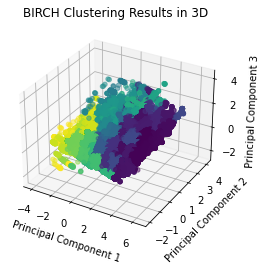

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca3['1st feature'], df_pca3['2nd feature'], df_pca3['3rd feature'],
                     c=df_pca3['Cluster'], cmap='viridis', alpha=0.5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('BIRCH Clustering Results in 3D')
plt.savefig('BIRCH_Clustering_3D.png', dpi=200)  
plt.show()

In [48]:
cluster_counts = Counter(labels)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label 3D', 'Percentage (%)'])
print(table_data)

     Cluster Label 3D  Percentage (%)
0                   0        0.265590
1                  49        2.556032
2                  18        0.020759
3                   1        0.304693
4                   2        0.326694
..                ...             ...
170                90        0.000690
171               169        0.002690
172                94        0.009241
173               106        0.000690
174               171        0.002345

[175 rows x 2 columns]


/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



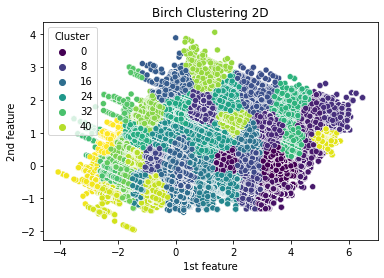

    Cluster Label 2D  Percentage (%)
0                 30        0.407660
1                  3        0.412902
2                 21        2.670585
3                  4        0.159726
4                  0        0.572904
5                 43        0.210416
6                  5        0.489041
7                  6        0.092277
8                  7        0.854562
9                 26        0.109105
10                39        0.709043
11                27        1.498639
12                 8        4.967303
13                29        0.080346
14                 2        2.110302
15                 1        2.113957
16                17        0.988771
17                10        1.798850
18                25        1.506984
19                22        3.055141
20                23        1.131255
21                11        0.083311
22                 9        5.169306
23                15        6.396700
24                13        0.568352
25                38        0.042069
2

In [49]:
df_pca2['Cluster'] = labels2
sns.scatterplot(x=df_pca2['1st feature'], y=df_pca2['2nd feature'], hue='Cluster', data=df_pca2, palette='viridis')
plt.title('Birch Clustering 2D')
plt.savefig('BIRCH_Clustering_2D_Simple.png', dpi=200) 
plt.show()


cluster_counts = Counter(labels2)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label 2D', 'Percentage (%)'])
print(table_data)